**Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

***Import and read csv file***

In [2]:
import csv

In [3]:
with open ('credit_card.csv') as file:
    reader= csv.reader(file)

In [4]:
df=pd.read_csv('credit_card.csv')
print (df.head(5))

   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0  


***Identify and get rid of duplicates***

In [5]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [6]:
df.duplicated().sum()

0

***Exploratory Data Analysis***

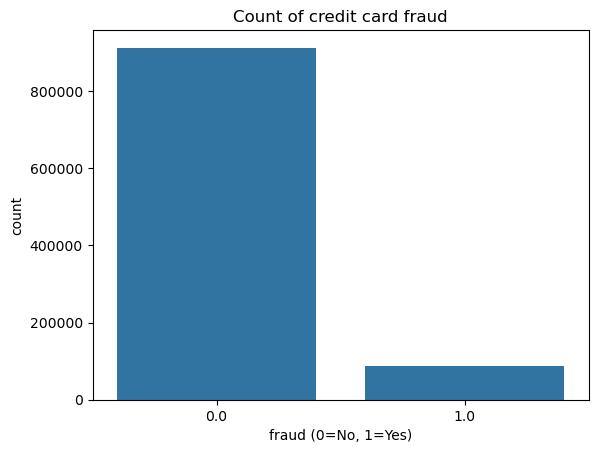

In [7]:
#What proportion of transactions are fradulent compared to legitimate ones?
sns.countplot(x='fraud',data=df)
plt.title('Count of credit card fraud')
plt.xlabel('fraud (0=No, 1=Yes)')
plt.ylabel('count')
plt.show()

In [8]:
fraud_summary = pd.DataFrame({
    'Count': df['fraud'].value_counts(),
    'Percentage (%)': df['fraud'].value_counts(normalize=True) * 100
})
fraud_summary

,Count,Percentage (%)
fraud,,
0.0,912597,91.2597
1.0,87403,8.7403


The dataset is highly imbalanced, with fraudulent transactions forming only a small percentage of total transactions.

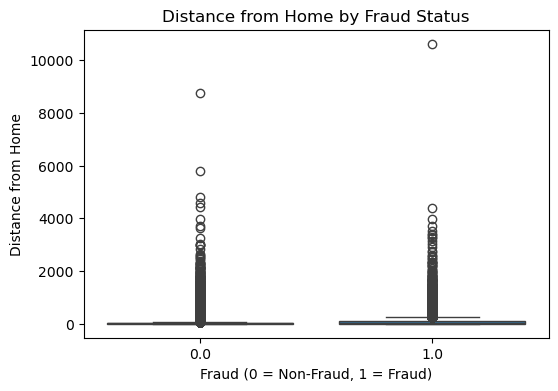

In [9]:
#Are fraudulent transactions more likely to happen far from home?

plt.figure(figsize=(6, 4))
sns.boxplot(x='fraud', y='distance_from_home', data=df)
plt.title('Distance from Home by Fraud Status')
plt.xlabel('Fraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Distance from Home')
plt.show()

The thin boxes near 0 show that most transactions happen very close to home. However, the outliers reveal a key pattern, indicating that transactions occuring very far from home are strong predictors of fraud amongst other factors. Therefore, extreme distances should be treated as highly suspicious. 

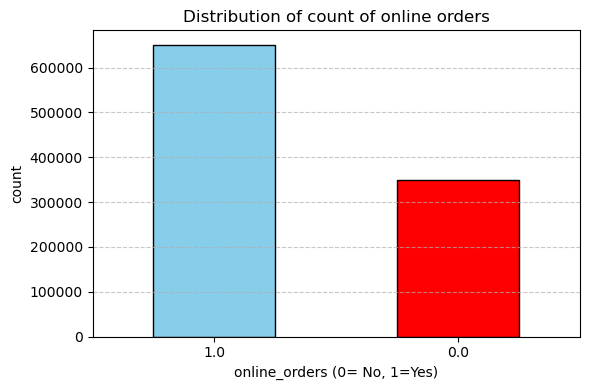

In [10]:
# Does online shopping increase fraud risk?

online_orders= df['online_order'].value_counts()
plt.figure(figsize=(6,4))
online_orders.plot(kind='bar',color=['skyblue','red'],edgecolor='black')
plt.title('Distribution of count of online orders')
plt.xlabel('online_orders (0= No, 1=Yes)')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()

There is a greater number of online orders, which could indicate the possibility of the occurrence of more fraudulent transactions. A number of reasons could cause more fraudulent transactions in purchasing items online. They include:
* Lack of physical card verification. In most cases, stolen cards can be used remotely.
* Some online purchases only require card numbers, expiry date and cvv. Most times, in an effort to save time and reduce stress in constantly inputing card details, this sensitive information could be saved to various online payment websites, which could give room for data breaching.
* Cardholders may not detect fraudulent online charges on time, which allows fraudsters to make the most out of online orders.

These are just a few reasons among others. 

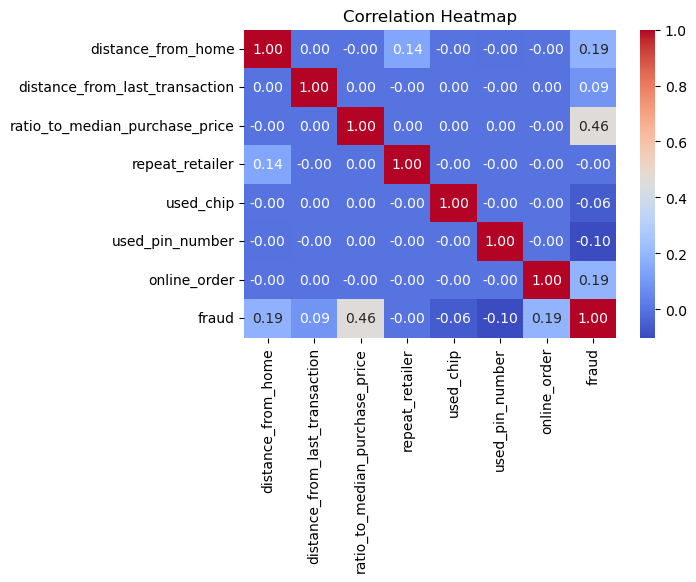

In [11]:
# What features are more related to fraud?

plt.figure(figsize=(6,4))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

From the visualization above, the column "ratio_to_median_purchase_price" has a stronger positive correlation with the column "fraud" compared to other columns. Therefore, we ask the question:

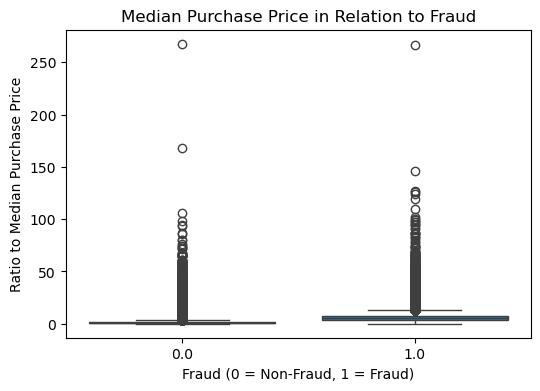

In [12]:
# Are fraudulent transactions more likely to have extreme purchase prices compared to normal transactions?

plt.figure(figsize=(6, 4))
sns.boxplot(x='fraud', y='ratio_to_median_purchase_price', data=df)
plt.title('Median Purchase Price in Relation to Fraud')
plt.xlabel('Fraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Ratio to Median Purchase Price')
plt.show()

Fraudulent transactions show significantly higher price deviation from the median, indicating abnormal spending patterns

**Data Preparation for Modeling**

In [13]:
#Split features and targets

#train-test split
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('fraud', axis=1)
y = df['fraud']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

**Model Selection, Training and Evaluation**

In this dataset, most transactions are normal, very few are fraudulent. These fraudulent transactions often happen far from home, are online and involve unusually large amounts. One single rule cannot catch all fraud. Therefore, a model that can combine many clues at once and pay extra attention to rare fraud cases is needed. XGBoost is the most appropriate model as it handles class imbalance very well and is robust to outliers amongst other reasons compared to other models. 

In [14]:
from xgboost import XGBClassifier

model = XGBClassifier(
    scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss'
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.98      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000

ROC-AUC: 0.9999708675253777


The model achieved very high recall for fraudulent transactions, indicating that nearly all fraud cases were successfully detected. Precision was also high, meaning few legitimate transactions were incorrectly flagged. The ROC-AUC score close to 1.0 confirms that the model effectively separates fraudulent and non-fraudulent transactions.

**Model Saving**

In [16]:
import pickle

with open("fraud_model.pkl", "wb") as f:
    pickle.dump(model, f)